# Problem Description
Tiny ImageNet contains 100000 images of 200 classes (500 for each class) downsized to 64×64 colored images. Each class has 500 training images, 50 validation images and 50 test images.

# Metrics
For the evaluation of the model, we will use accuracy as our metric. It is straightforward and defined as follows:
$$ \text{Accuracy} = \frac{\text{correct classifications}}{\text{all classifications}} $$

However, accuracy has a disadvantage for multiclass classification problems, as it does not consider class imbalances. If our model is biased towards one class, and that class has the highest occurrence, accuracy may fail to reflect this bias. In our case, since the dataset does not have class imbalances, accuracy should be sufficient for our evaluation.

To estimate the error in the chosen metric, we could also consider using an alternative metric like the F1 Score, which penalizes false predictions rather than just summarizing the correct ones.


# Base Architecture
- The base model consists of two convolutional layers for feature extraction and two pooling layers to reduce the spatial dimension of the image. Two fully connected layer ensure enough parameters. The goal is to train with a single sample or batch and to show that it works as well as in the next step to find a proper learning rate and batch size.

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import utils
from typing import List, Tuple, Dict


class CNN(nn.Module):
    def __init__(
        self,
        dim: int,
        num_classes: int,
        confs: List[Tuple[str, Dict]],
        in_channels: int,
        weight_init=None,
    ):
        super(CNN, self).__init__()

        self.net = nn.ModuleList()

        linear_idxs = [idx for idx, (layer, _) in enumerate(confs) if layer == "L"]
        linear_start = linear_idxs[0]
        convolution_conf = confs[:linear_start]
        linear_conf = confs[linear_start:]
        for layer, conf in convolution_conf:
            if layer == "C":
                self.net.append(
                    nn.Conv2d(
                        in_channels,
                        out_channels=conf["channels"],
                        kernel_size=conf["kernel"],
                        stride=conf.get("stride", 1),
                        padding=conf.get("padding", 0),
                    )
                )
                self.net.append(nn.ReLU())
                if conf.get("batch_norm", False):
                    self.net.append(nn.BatchNorm2d(conf["channels"]))
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
                in_channels = conf["channels"]
            elif layer == "P":
                self.net.append(nn.MaxPool2d(kernel_size=conf["kernel"]))
            else:
                raise NotImplementedError(f"Layer {layer} not implemented")

        self.dim = utils.get_dim_after_conv_and_pool(dim_init=dim, confs=confs)
        for idx, (layer, conf) in enumerate(linear_conf):
            if idx == 0:
                self.net.append(nn.Flatten())
                self.net.append(
                    nn.Linear(self.dim * self.dim * in_channels, conf["units"])
                )
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
            elif idx == len(linear_conf) - 1:
                self.net.append(nn.Linear(conf["units"], num_classes))
            else:
                self.net.append(nn.Linear(conf["units"], conf["units"]))
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))

    def forward(self, x):
        N, H, W, C = x.shape
        x = x.permute(
            0, 3, 1, 2
        )  # Adjust (batch_size, H, W, C) to (batch_size, C, H, W)
        assert x.shape == (N, C, H, W)

        for layer in self.net:
            x = layer(x)

        return x

/Users/hariveliki/miniconda3/envs/eml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
]

In [3]:
x = torch.rand(10, 64, 64, 3)
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
model(x)
summary(model, (64, 64, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
         MaxPool2d-3           [-1, 16, 31, 31]               0
            Conv2d-4           [-1, 32, 29, 29]           4,640
              ReLU-5           [-1, 32, 29, 29]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
           Flatten-7                 [-1, 6272]               0
            Linear-8                  [-1, 500]       3,136,500
              ReLU-9                  [-1, 500]               0
           Linear-10                  [-1, 200]         100,200
Total params: 3,241,788
Trainable params: 3,241,788
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.57
Params size (MB): 12.37
Estima

In [4]:
train_loader, valid_loader = utils.get_data(batch_size=None)
print(train_loader, valid_loader)

<torch.utils.data.dataloader.DataLoader object at 0x106fb10c0> <torch.utils.data.dataloader.DataLoader object at 0x106fb0340>


## Discussion

# SGD, Tuning of Learning Rate and Batch Size
- Stochastic Gradient Descent (SGD) is an optimization method in deep learning. Unlike traditional gradient descent, where we train on the entire dataset, SGD updates model parameters using a small batch of the data. This enables faster learning, say faster convergence to local (global) minima, and is therefore more efficient.
- The learning rate controls how much the model's weights are adjusted in response to the error at each step of training. A small learning rate increases the training time, while a large learning rate speeds up training but can cause the model to overshoot and fail to converge.
- The batch size refers to the number of training examples used for updating the model's weights. The key idea is that using smaller groups to update the weights will also allow the model to generalize well, as the batch acts as a proxy for the whole dataset.

First, we'll conduct an overfitting test by training on a small dataset of 100 samples, expecting the loss to decrease and accuracy to increase. Then, we'll search for the highest learning rate that still allows convergence. Finally, we'll determine a batch size that is memory efficient and balances representation of the data statistics with minimizing noise.

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from cnn_base import CNN
from utils import get_data


def train(model, epochs, train_loader, criterion, optimizer, device=None):
    loss_train_hist = []
    train_accuracy_hist = []
    for epoch in range(epochs):
        print(
            f"|---------------------------| Start Epoch {epoch}: |---------------------------|"
        )
        loss_train = 0
        total = 0
        correct = 0
        model.train()
        for idx, (imgs, labels) in enumerate(train_loader):
            if imgs.dim() == 3:
                imgs = imgs.unsqueeze(0)
            if isinstance(labels, int):
                labels = torch.tensor([labels])
            if device is not None:
                imgs = imgs.to(device)
                labels = labels.to(device)
            # Forward pass
            labels = labels.long()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss_train += loss.item()
            preds = nn.functional.softmax(logits, dim=1)
            predicted = preds.argmax(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_train /= len(train_loader)
        loss_train_hist.append(loss_train)
        train_accuracy = 100 * correct / total
        train_accuracy_hist.append(train_accuracy)
        print(f"Train Loss: {loss_train}")
        print(f"Train Accuracy: {train_accuracy}")
    return loss_train_hist, train_accuracy_hist

Training length:  1
|---------------------------| Start Epoch 0: |---------------------------|
Epoch 0, Loss: 5.298584461212158
Train Loss: 5.298584461212158
Train Accuracy: 0.0
|---------------------------| Start Epoch 1: |---------------------------|
Epoch 1, Loss: 5.287440776824951
Train Loss: 5.287440776824951
Train Accuracy: 1.0
|---------------------------| Start Epoch 2: |---------------------------|
Epoch 2, Loss: 5.2762956619262695
Train Loss: 5.2762956619262695
Train Accuracy: 1.0
|---------------------------| Start Epoch 3: |---------------------------|
Epoch 3, Loss: 5.2652740478515625
Train Loss: 5.2652740478515625
Train Accuracy: 2.0
|---------------------------| Start Epoch 4: |---------------------------|
Epoch 4, Loss: 5.254425525665283
Train Loss: 5.254425525665283
Train Accuracy: 4.0
|---------------------------| Start Epoch 5: |---------------------------|
Epoch 5, Loss: 5.243680000305176
Train Loss: 5.243680000305176
Train Accuracy: 3.0
|---------------------------

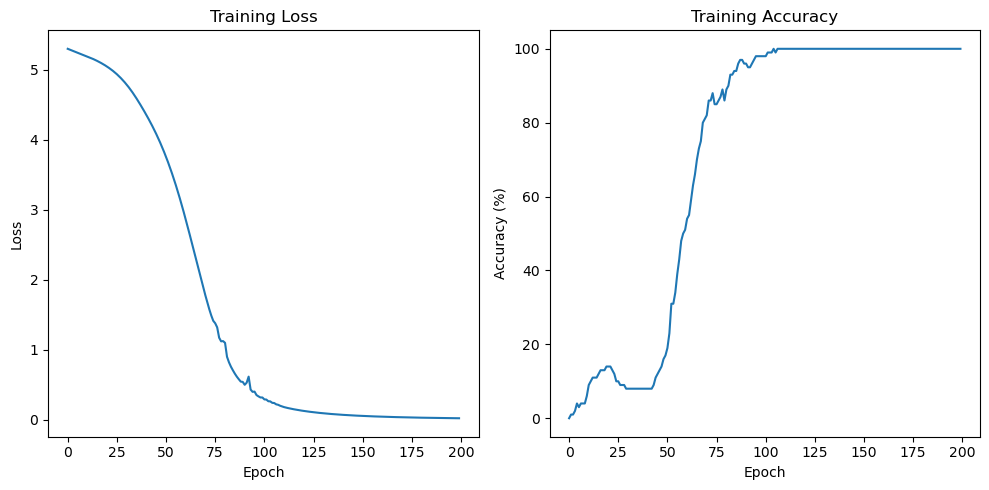

In [17]:
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
]
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
train_loader, valid_loader = get_data(batch_size=100, subset_size=100, seed=42)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_train, train_accuracy = train(
    model,
    epochs=200,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=None,
)
# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_train)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()


In [46]:
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
]
device = torch.device("mps" if torch.backends.mps.is_available() else None)
criterion = nn.CrossEntropyLoss()
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64]
results = {}
epochs = 10
for lr in learning_rates:
    print(f"Learning rate: {lr}")
    for bs in batch_sizes:
        print(f"Batch size: {bs}")
        train_loader, valid_loader = get_data(batch_size=bs, seed=42)
        model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
        if device is not None:
            model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        loss_train, train_accuracy = train(
            model,
            epochs=epochs,
            train_loader=train_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
        )
        results[(lr, bs)] = (loss_train, train_accuracy)

Learning rate: 0.0001
Batch size: 32
|---------------------------| Start Epoch 0: |---------------------------|
Train Loss: 5.299177282714844
Train Accuracy: 0.497
|---------------------------| Start Epoch 1: |---------------------------|
Train Loss: 5.2972902526855465
Train Accuracy: 0.554
|---------------------------| Start Epoch 2: |---------------------------|
Train Loss: 5.295520900268555
Train Accuracy: 0.655
|---------------------------| Start Epoch 3: |---------------------------|
Train Loss: 5.293797625732422
Train Accuracy: 0.75
|---------------------------| Start Epoch 4: |---------------------------|
Train Loss: 5.292057313842774
Train Accuracy: 0.817
|---------------------------| Start Epoch 5: |---------------------------|
Train Loss: 5.290228044128418
Train Accuracy: 0.901
|---------------------------| Start Epoch 6: |---------------------------|
Train Loss: 5.288258346557617
Train Accuracy: 0.954
|---------------------------| Start Epoch 7: |---------------------------|

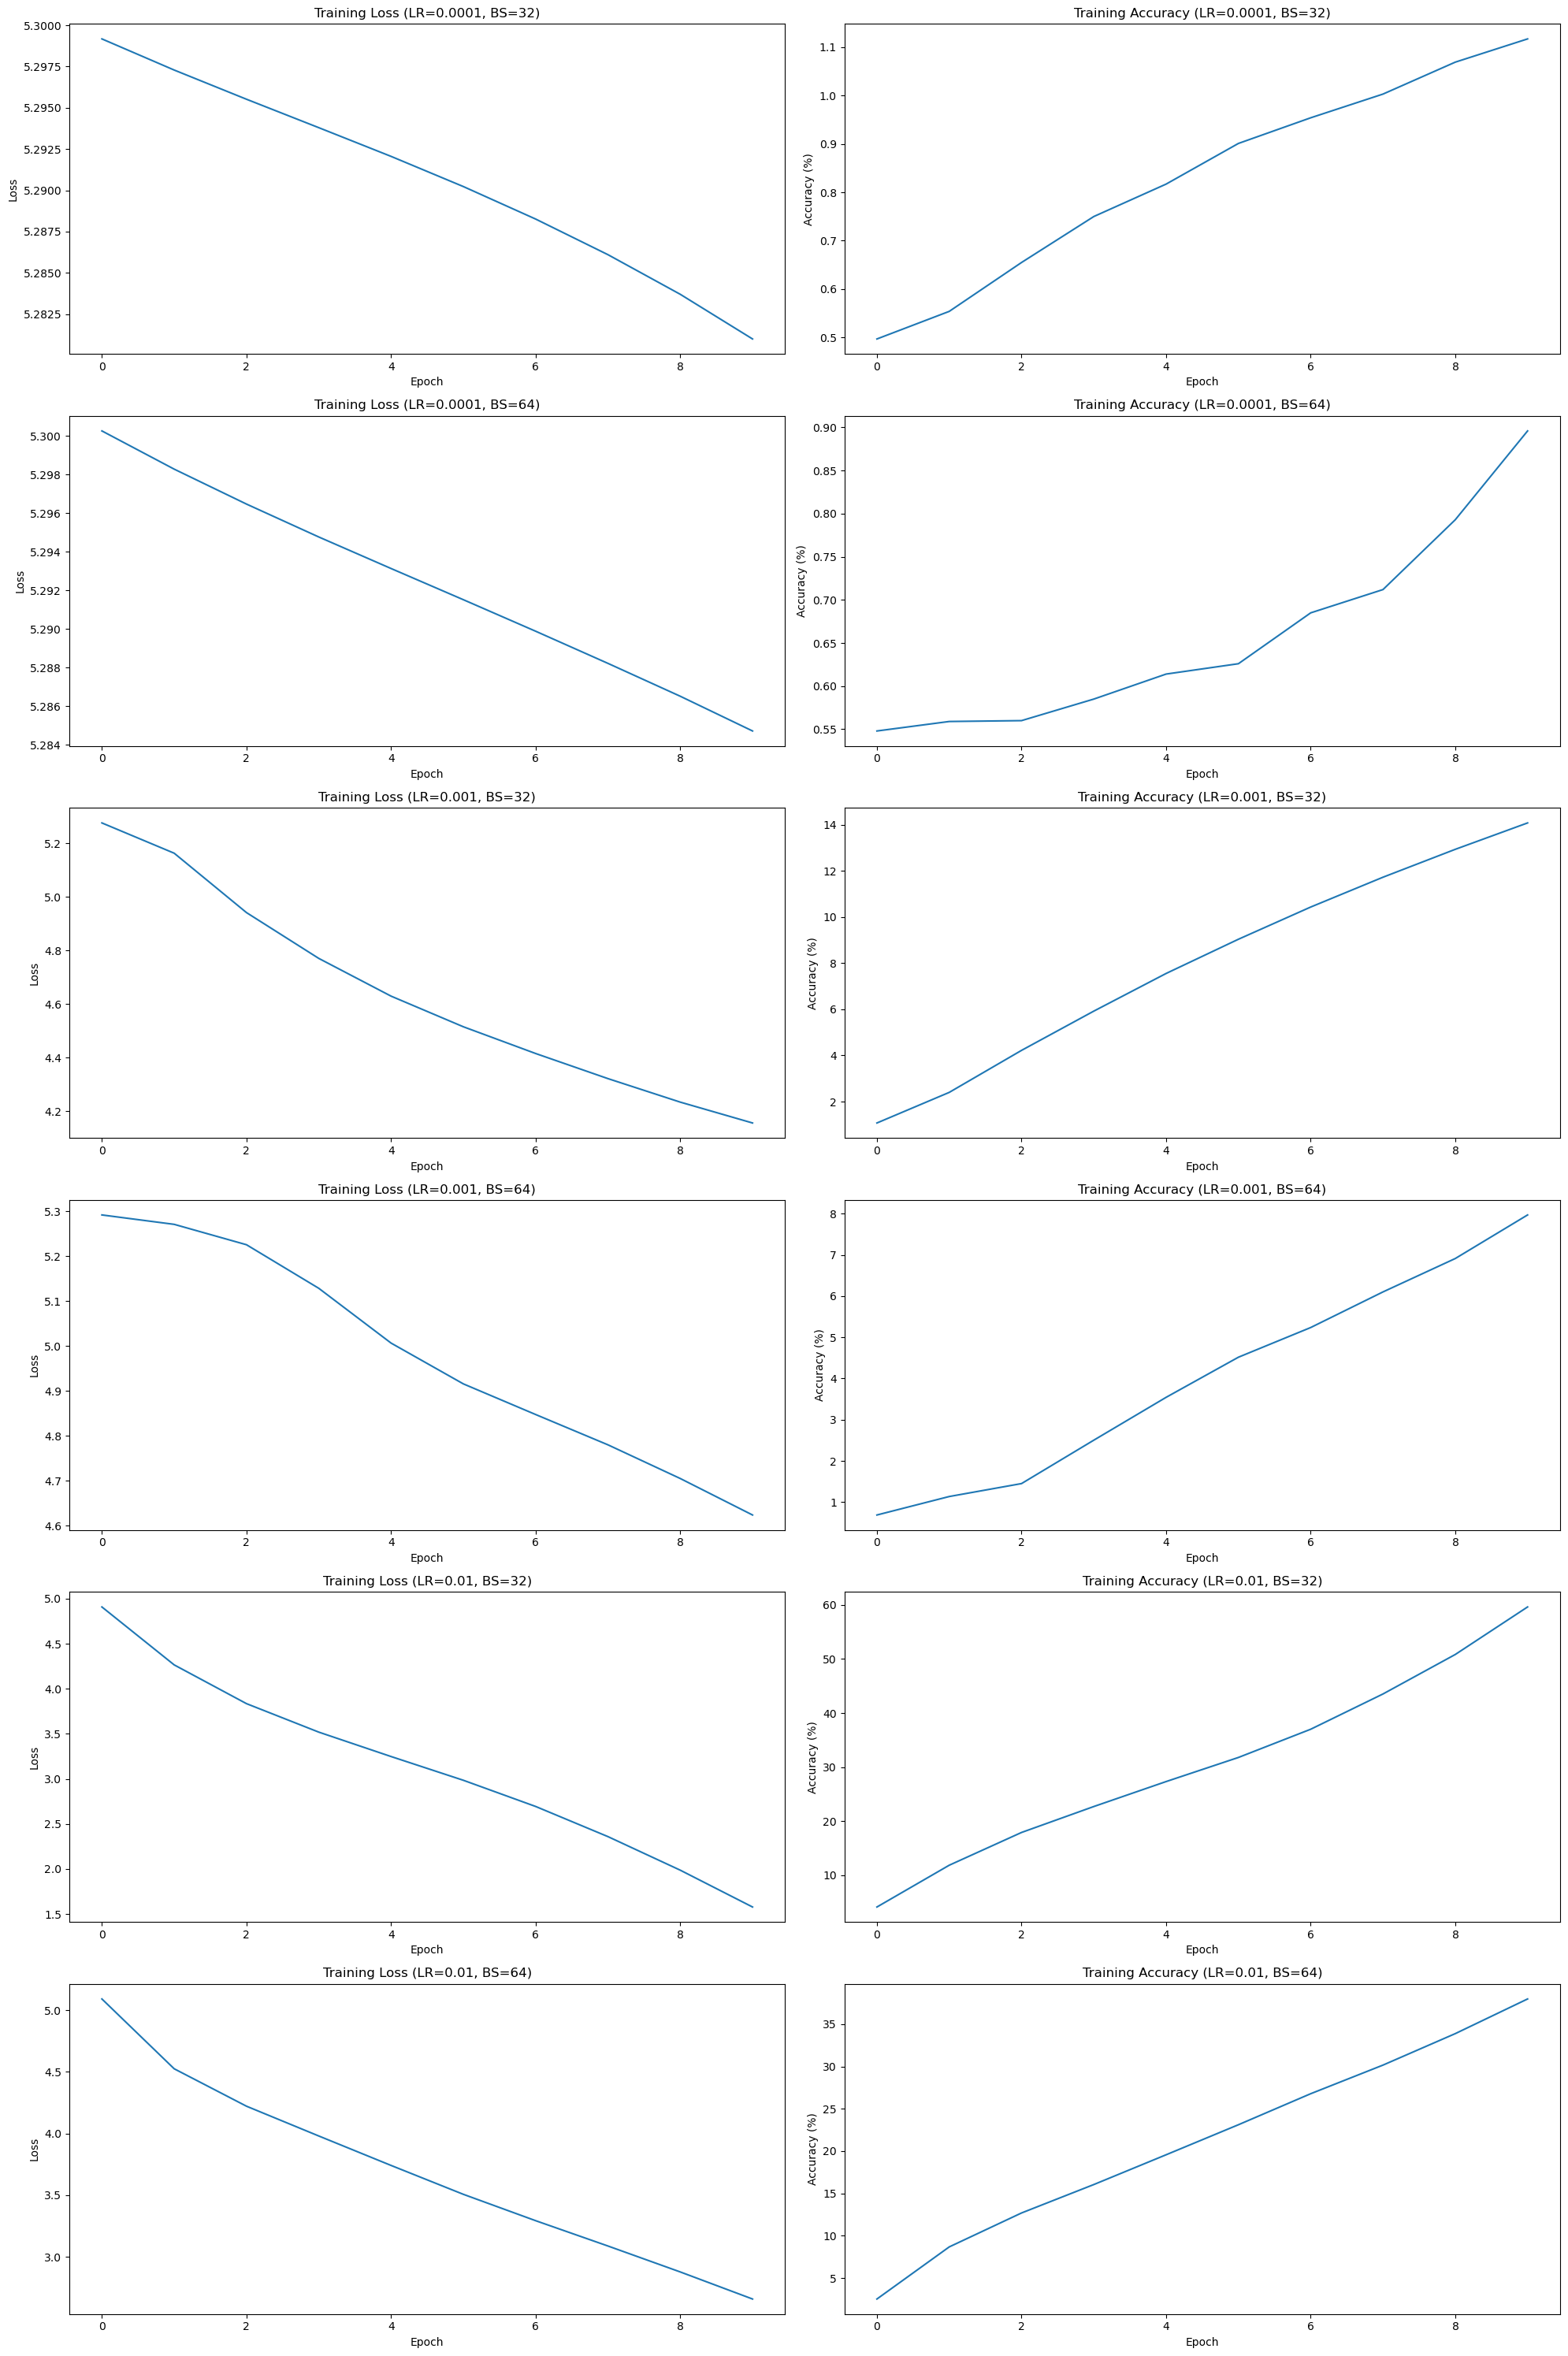

In [47]:
plt.figure(figsize=(20, 30))  # Increased figure size to accommodate more subplots
for i, ((lr, bs), (loss, accuracy)) in enumerate(results.items()):
    # Plot Training Loss
    plt.subplot(len(results), 2, 2*i + 1)
    plt.plot(loss)
    plt.title(f'Training Loss (LR={lr}, BS={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Training Accuracy
    plt.subplot(len(results), 2, 2*i + 2)
    plt.plot(accuracy)
    plt.title(f'Training Accuracy (LR={lr}, BS={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()

## Discussion
Our overfitting test with SGD and 100 samples (full batch) shows that the algorithm works. It convergences as expected and the accuracy increases up to 100% and shows clearly overfitting.

# SGD, Weight Initialization, Model Complexity, Convolution Settings
- Explain what you will do here

## Weight Initialization
- Explain the different weight initialization methods

In [6]:
def my_code():
    pass

### Discussion

## Model Complexity
- Explain what you will do

### Model Variant 1
- Explain

In [7]:
import torch
import torch.nn as nn
import utils
from typing import List, Tuple, Dict


class CNN(nn.Module):
    def __init__(
        self,
        dim: int,
        num_classes: int,
        confs: List[Tuple[str, Dict]],
        in_channels: int,
        weight_init=None,
    ):
        super(CNN, self).__init__()

        self.net = nn.ModuleList()

        linear_idxs = [idx for idx, (layer, _) in enumerate(confs) if layer == "L"]
        linear_start = linear_idxs[0]
        convolution_conf = confs[:linear_start]
        linear_conf = confs[linear_start:]
        for layer, conf in convolution_conf:
            if layer == "C":
                self.net.append(
                    nn.Conv2d(
                        in_channels,
                        out_channels=conf["channels"],
                        kernel_size=conf["kernel"],
                        stride=conf.get("stride", 1),
                        padding=conf.get("padding", 0),
                    )
                )
                self.net.append(nn.ReLU())
                if conf.get("batch_norm", False):
                    self.net.append(nn.BatchNorm2d(conf["channels"]))
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
                in_channels = conf["channels"]
            elif layer == "P":
                self.net.append(nn.MaxPool2d(kernel_size=conf["kernel"]))
            else:
                raise NotImplementedError(f"Layer {layer} not implemented")

        self.dim = utils.get_dim_after_conv_and_pool(dim_init=dim, confs=confs)
        print(f"self.dim: {self.dim},\nin_channels: {in_channels}")
        for idx, (layer, conf) in enumerate(linear_conf):
            if idx == 0:
                self.net.append(nn.Flatten())
                self.net.append(
                    nn.Linear(self.dim * self.dim * in_channels, conf["units"])
                )
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
            elif idx == len(linear_conf) - 1:
                self.net.append(nn.Linear(conf["units"], num_classes))
            else:
                self.net.append(nn.Linear(conf["units"], conf["units"]))
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))

    def forward(self, x):
        N, H, W, C = x.shape
        x = x.permute(
            0, 3, 1, 2
        )  # Adjust (batch_size, H, W, C) to (batch_size, C, H, W)
        assert x.shape == (N, C, H, W)

        for layer in self.net:
            x = layer(x)

        return x

### Model Variant 2
- Explain

In [8]:
import torch
import torch.nn as nn
import utils
from typing import List, Tuple, Dict


class CNN(nn.Module):
    def __init__(
        self,
        dim: int,
        num_classes: int,
        confs: List[Tuple[str, Dict]],
        in_channels: int,
        weight_init=None,
    ):
        super(CNN, self).__init__()

        self.net = nn.ModuleList()

        linear_idxs = [idx for idx, (layer, _) in enumerate(confs) if layer == "L"]
        linear_start = linear_idxs[0]
        convolution_conf = confs[:linear_start]
        linear_conf = confs[linear_start:]
        for layer, conf in convolution_conf:
            if layer == "C":
                self.net.append(
                    nn.Conv2d(
                        in_channels,
                        out_channels=conf["channels"],
                        kernel_size=conf["kernel"],
                        stride=conf.get("stride", 1),
                        padding=conf.get("padding", 0),
                    )
                )
                self.net.append(nn.ReLU())
                if conf.get("batch_norm", False):
                    self.net.append(nn.BatchNorm2d(conf["channels"]))
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
                in_channels = conf["channels"]
            elif layer == "P":
                self.net.append(nn.MaxPool2d(kernel_size=conf["kernel"]))
            else:
                raise NotImplementedError(f"Layer {layer} not implemented")

        self.dim = utils.get_dim_after_conv_and_pool(dim_init=dim, confs=confs)
        print(f"self.dim: {self.dim},\nin_channels: {in_channels}")
        for idx, (layer, conf) in enumerate(linear_conf):
            if idx == 0:
                self.net.append(nn.Flatten())
                self.net.append(
                    nn.Linear(self.dim * self.dim * in_channels, conf["units"])
                )
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
            elif idx == len(linear_conf) - 1:
                self.net.append(nn.Linear(conf["units"], num_classes))
            else:
                self.net.append(nn.Linear(conf["units"], conf["units"]))
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))

    def forward(self, x):
        N, H, W, C = x.shape
        x = x.permute(
            0, 3, 1, 2
        )  # Adjust (batch_size, H, W, C) to (batch_size, C, H, W)
        assert x.shape == (N, C, H, W)

        for layer in self.net:
            x = layer(x)

        return x

### Model Variant 3
- Explain

In [9]:
import torch
import torch.nn as nn
import utils
from typing import List, Tuple, Dict


class CNN(nn.Module):
    def __init__(
        self,
        dim: int,
        num_classes: int,
        confs: List[Tuple[str, Dict]],
        in_channels: int,
        weight_init=None,
    ):
        super(CNN, self).__init__()

        self.net = nn.ModuleList()

        linear_idxs = [idx for idx, (layer, _) in enumerate(confs) if layer == "L"]
        linear_start = linear_idxs[0]
        convolution_conf = confs[:linear_start]
        linear_conf = confs[linear_start:]
        for layer, conf in convolution_conf:
            if layer == "C":
                self.net.append(
                    nn.Conv2d(
                        in_channels,
                        out_channels=conf["channels"],
                        kernel_size=conf["kernel"],
                        stride=conf.get("stride", 1),
                        padding=conf.get("padding", 0),
                    )
                )
                self.net.append(nn.ReLU())
                if conf.get("batch_norm", False):
                    self.net.append(nn.BatchNorm2d(conf["channels"]))
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
                in_channels = conf["channels"]
            elif layer == "P":
                self.net.append(nn.MaxPool2d(kernel_size=conf["kernel"]))
            else:
                raise NotImplementedError(f"Layer {layer} not implemented")

        self.dim = utils.get_dim_after_conv_and_pool(dim_init=dim, confs=confs)
        print(f"self.dim: {self.dim},\nin_channels: {in_channels}")
        for idx, (layer, conf) in enumerate(linear_conf):
            if idx == 0:
                self.net.append(nn.Flatten())
                self.net.append(
                    nn.Linear(self.dim * self.dim * in_channels, conf["units"])
                )
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
            elif idx == len(linear_conf) - 1:
                self.net.append(nn.Linear(conf["units"], num_classes))
            else:
                self.net.append(nn.Linear(conf["units"], conf["units"]))
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))

    def forward(self, x):
        N, H, W, C = x.shape
        x = x.permute(
            0, 3, 1, 2
        )  # Adjust (batch_size, H, W, C) to (batch_size, C, H, W)
        assert x.shape == (N, C, H, W)

        for layer in self.net:
            x = layer(x)

        return x

### Model Variant 4
- Explain

In [10]:
import torch
import torch.nn as nn
import utils
from typing import List, Tuple, Dict


class CNN(nn.Module):
    def __init__(
        self,
        dim: int,
        num_classes: int,
        confs: List[Tuple[str, Dict]],
        in_channels: int,
        weight_init=None,
    ):
        super(CNN, self).__init__()

        self.net = nn.ModuleList()

        linear_idxs = [idx for idx, (layer, _) in enumerate(confs) if layer == "L"]
        linear_start = linear_idxs[0]
        convolution_conf = confs[:linear_start]
        linear_conf = confs[linear_start:]
        for layer, conf in convolution_conf:
            if layer == "C":
                self.net.append(
                    nn.Conv2d(
                        in_channels,
                        out_channels=conf["channels"],
                        kernel_size=conf["kernel"],
                        stride=conf.get("stride", 1),
                        padding=conf.get("padding", 0),
                    )
                )
                self.net.append(nn.ReLU())
                if conf.get("batch_norm", False):
                    self.net.append(nn.BatchNorm2d(conf["channels"]))
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
                in_channels = conf["channels"]
            elif layer == "P":
                self.net.append(nn.MaxPool2d(kernel_size=conf["kernel"]))
            else:
                raise NotImplementedError(f"Layer {layer} not implemented")

        self.dim = utils.get_dim_after_conv_and_pool(dim_init=dim, confs=confs)
        print(f"self.dim: {self.dim},\nin_channels: {in_channels}")
        for idx, (layer, conf) in enumerate(linear_conf):
            if idx == 0:
                self.net.append(nn.Flatten())
                self.net.append(
                    nn.Linear(self.dim * self.dim * in_channels, conf["units"])
                )
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
            elif idx == len(linear_conf) - 1:
                self.net.append(nn.Linear(conf["units"], num_classes))
            else:
                self.net.append(nn.Linear(conf["units"], conf["units"]))
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))

    def forward(self, x):
        N, H, W, C = x.shape
        x = x.permute(
            0, 3, 1, 2
        )  # Adjust (batch_size, H, W, C) to (batch_size, C, H, W)
        assert x.shape == (N, C, H, W)

        for layer in self.net:
            x = layer(x)

        return x

### Discussion
- Variant 1
- Variant 2
- Variant 3
- Variant 4

# Regularization
- Briefly describe what the goal of regularization methods in general is

## L1/L2
- Explain

In [11]:
def my_code():
    pass

## Dropout
- Explain

In [12]:
def my_code():
    pass

## Discussion
- To what extent is this goal achieved in the given case?

# Batchnorm (without REG, with SGD)
- Evaluate whether Batchnorm is useful. Describe what the idea of BN is, what it is supposed to help.

In [13]:
def my_code():
    pass

## Discussion

# Adam
- Explain

## Without BN, without REG
- Explain

In [14]:
def my_code():
    pass

## Without BN, with REG
- Explain

In [15]:
def my_code():
    pass

## Discussion

# Transfer Learning
- Explain

In [16]:
def my_code():
    pass

## Discussion

# Conclusion